In [1]:
!wget https://dbdmg.polito.it/dbdmg_web/wp-content/uploads/2021/12/DSL2122_january_dataset.zip

--2022-01-03 18:48:09--  https://dbdmg.polito.it/dbdmg_web/wp-content/uploads/2021/12/DSL2122_january_dataset.zip
Resolving dbdmg.polito.it (dbdmg.polito.it)... 130.192.163.163
Connecting to dbdmg.polito.it (dbdmg.polito.it)|130.192.163.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18640208 (18M) [application/zip]
Saving to: ‘DSL2122_january_dataset.zip’

DSL2122_january_dat 100%[===================>]  17.78M  14.1MB/s    in 1.3s    

2022-01-03 18:48:11 (14.1 MB/s) - ‘DSL2122_january_dataset.zip’ saved [18640208/18640208]



In [2]:
!unzip DSL2122_january_dataset.zip

Archive:  DSL2122_january_dataset.zip
   creating: DSL2122_january_dataset/
  inflating: DSL2122_january_dataset/development.csv  
  inflating: __MACOSX/DSL2122_january_dataset/._development.csv  
  inflating: DSL2122_january_dataset/sample_submission.csv  
  inflating: __MACOSX/DSL2122_january_dataset/._sample_submission.csv  
  inflating: DSL2122_january_dataset/evaluation.csv  
  inflating: __MACOSX/DSL2122_january_dataset/._evaluation.csv  


In [31]:
import pandas as pd
import numpy as np

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression


# nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords as sw


# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Word2vec
import gensim

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [5]:
df = pd.read_csv('/content/DSL2122_january_dataset/development.csv', index_col=1)

In [ ]:
df.head()

,sentiment,date,flag,user,text
ids,,,,,
1833972543,1,Mon May 18 01:08:27 PDT 2009,NO_QUERY,Killandra,"@MissBianca76 Yes, talking helps a lot.. going..."
1980318193,1,Sun May 31 06:23:17 PDT 2009,NO_QUERY,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...
1994409198,1,Mon Jun 01 11:52:54 PDT 2009,NO_QUERY,yaseminx3,@PleaseBeMine Something for your iphone
1824749377,0,Sun May 17 02:45:34 PDT 2009,NO_QUERY,no_surprises,@GabrielSaporta couldn't get in to the after p...
2001199113,0,Tue Jun 02 00:08:07 PDT 2009,NO_QUERY,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...


# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224994 entries, 1833972543 to 2016018811
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  224994 non-null  int64 
 1   date       224994 non-null  object
 2   flag       224994 non-null  object
 3   user       224994 non-null  object
 4   text       224994 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.3+ MB


In [ ]:
df.flag.unique()

array(['NO_QUERY'], dtype=object)

There's no need in keep on 'flag' attribute with us.


Let's see if there's some imbalancing:

Text(0.5, 1.0, 'Dataset labels distribution')

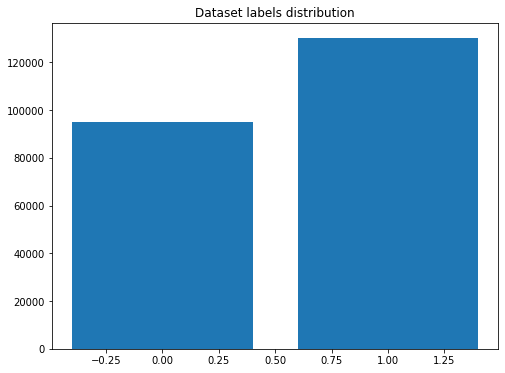

In [ ]:
sentiment_count = Counter(df.sentiment)

plt.figure(figsize=(8,6))
plt.bar(sentiment_count.keys(), sentiment_count.values())
plt.title('Dataset labels distribution')

# First benchmark:

We'll use only the text as features..

In [ ]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df.text)

In [ ]:
X_tfidf.shape

(224994, 156707)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df.sentiment, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, y_train.shape

((179995, 156707), (179995,))

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))

Accuracy:  0.702926731705149
f1 score:  0.7437509584419568


# Preprocessing:

Lemmatization and Stopwords elimination:

In [ ]:
class LemmaTokenizer(object):
  def __init__(self):
    self.lemmatizer = WordNetLemmatizer()


  def __call__(self, document):
    lemmas = []
    for t in word_tokenize(document):
      t = t.strip()
      lemma = self.lemmatizer.lemmatize(t)
      lemmas.append(lemma)
    return lemmas


lemmaTokenizer = LemmaTokenizer()
vectorizer = TfidfVectorizer(tokenizer=lemmaTokenizer, stop_words=stopwords.words('english'))
X_tfidf = vectorizer.fit_transform(df.text)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  % sorted(inconsistent)


Performances after lemmatization and stopwords elimination:



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df.sentiment, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(179995, 173979)

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))

Accuracy:  0.6928820640458677
f1 score:  0.7392256019322212


Let's try stopword removal only:

you can make a set of stopwords and remove some of the words using the remove function.

stoplist = set(stopwords.words("english")
stoplist.remove('Not').

You can then use this set to filter out the list of stopwords you want.



In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X_tfidf = vectorizer.fit_transform(df.text)

In [ ]:
X_tfidf.shape

(224994, 156563)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df.sentiment, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, y_train.shape

((179995, 156563), (179995,))

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))

Accuracy:  0.7093268739305318
f1 score:  0.7520191104538733


It's clear that lemmatization worsen the performances.. this can happen because abbreviations, like punctuation, can be relevant to sentiment detection.
The problem is that default tokenization used by TfidfVectorizer explicitly ignores all punctuation.

We can modify **token_pattern** in Tfidf_vectorizer to be any character except one or more whitespaces:



In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), token_pattern=r'[^\s]+')
X_tfidf = vectorizer.fit_transform(df.text)
print("Shape after tf-idf: ", X_tfidf.shape)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df.sentiment, test_size=0.2, random_state=42)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))

Shape after tf-idf:  (224994, 263344)
Accuracy:  0.7001488921976043
f1 score:  0.7436594030814827


If we want to modify the hyperparameters of the tf-idf model, we should tune 


1.   Term frequency weighting. Recall that the term frequency is the normalized count of terms in a given document. This value can be set to:
• b - binary,
• t or n - raw,
• a - augmented,
• l - logarithm,
• d - double logarithm,
• L - log average.

2.   Document frequency weighting. Recall that the document frequency is the number of documents in a corpus that contain a given term. This value can be set to:
• x or n - none,
• f - idf,
• t - zero-corrected idf,
• p - probabilistic idf.
3.   Document normalization. Each document is normalized so that all document vectors are turned into unit vectors. In doing so, we eliminate all information on the length of the original document; this masks some subtleties about longer documents. First, longer documents will — as a result of containing more terms — have higher term frequency values. Second, longer documents contain more distinct terms. The document normalization can be set to:
• x or n - none,
• c - cosine,
• u - pivoted unique,
• b - pivoted character length.





In [ ]:
param_grid = {'tfidf__use_idf': (True, False),
              'tfidf__min_df': [1, 2, 3],
              'tfidf__stop_words': [stopwords.words('english'), None],
              'tfidf__token_pattern': (r'[^\s]+', '(?u)\b\w\w+\b')}

pipeline = Pipeline([("tfidf", TfidfVectorizer()),
                    ("clf", DecisionTreeClassifier())])

grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1, verbose=1)

# we randomly sample from the df to perform grid search in a less time
red_df = df.sample(frac=0.1, random_state=42)

grid_search.fit(red_df.text, red_df.sentiment)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 355, in _fit
    **fit_params_steps[name],
  File "/usr/local/lib/python3.7/dist-packages/joblib/memory.py", lin

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'tfidf__min_df': [1, 2, 3],
                         'tfidf__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd", 'your',
                                                'yours', 'yourself',
                                                'yourselves', 'he', 'him',
                                                'his', 'himself', 'she',
                                                "she's", 'her', 'hers',
                                                'herself', 'it', "it's", 'its',
                                                'itself', ...],
                                      

In [ ]:
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.686
Best parameters set:
	tfidf__min_df: 2
	tfidf__stop_words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other

Other preprocessing:

In [6]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused',
          '$_$': 'greedy','@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused','<(-_-)>': 'robot', 'd[-_-]b': 'dj', 
          ":'-)": 'sadsmile',';)': 'wink',';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [39]:
def preprocess(text):
    processedText = []
    
    # Defining regex patterns.
    urlPattern        = r"(http|https|ftp)://[a-zA-Z0-9\\./]+"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in text:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        #tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        #tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        processedText.append(tweet)
        
    return processedText

In [40]:
X_preproc = preprocess(list(df['text']))
y = df['sentiment']

In [24]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(X_preproc)
print("Shape after tf-idf: ", X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))

Shape after tf-idf:  (224994, 74271)
Accuracy:  0.7055045667681504
f1 score:  0.7492810655365522


In [25]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), use_idf=False)
X = vectorizer.fit_transform(X_preproc)
print("Shape after tf-idf: ", X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))

Shape after tf-idf:  (224994, 74271)
Accuracy:  0.7053934531878486
f1 score:  0.7505973097544917


Let's try linearSVC:

In [34]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), use_idf=False)
X = vectorizer.fit_transform(X_preproc)
print("Shape after tf-idf: ", X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))

Shape after tf-idf:  (224994, 74271)
Accuracy:  0.77397275495011
f1 score:  0.8109725500399576


Let's try Logistic regression:


In [43]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(df.text)
print("Shape after tf-idf: ", X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_clf = LogisticRegression(max_iter = 5000, n_jobs=-1)
log_clf.fit(X_train,y_train)
y_pred = log_clf.predict(X_test)

print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))

Shape after tf-idf:  (224994, 156563)
Accuracy:  0.7799062201382253
f1 score:  0.818208516886931


In [42]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(X_preproc)
print("Shape after tf-idf: ", X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_clf = LogisticRegression(max_iter = 5000, n_jobs=-1)
log_clf.fit(X_train,y_train)
y_pred = log_clf.predict(X_test)

print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))

Shape after tf-idf:  (224994, 79164)
Accuracy:  0.7757505722349386
f1 score:  0.814021636963453
